In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent.parent
DIR_PATH = Path().resolve()
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))

In [3]:
from glob import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import PyPDF2
import soundfile as sf
from frequency_response import FrequencyResponse
from biquad import digital_coeffs, peaking
from research.limited_gradient_smoothing.utils import log_log_gradient, limited_slope_plots

## Frequency Response Creation Utils

In [30]:
def iir_fr(fc, Q, gain):
    fs = 48000
    fr = FrequencyResponse(name='peaking')
    fr.raw = np.zeros(fr.frequency.shape)
    for __fc, __Q, __gain in zip(fc, Q, gain):
        a0, a1, a2, b0, b1, b2 = peaking(__fc, __Q, __gain, fs=fs)
        fr.raw += digital_coeffs(fr.frequency, fs, a0, a1, a2, b0, b1, b2)
    return fr

def equalization(measurement_path, target_path):
    fr = FrequencyResponse.read_from_csv(measurement_path)
    target = FrequencyResponse.read_from_csv(target_path)
    fr.compensate(target, bass_boost_gain=-2)
    fr.raw = -fr.error
    fr.reset()
    return fr

def write_ir(fr):
    ir = fr.minimum_phase_impulse_response(fs=48000, f_res=10, normalize=True)
    DIR_PATH.joinpath('ir').mkdir(exist_ok=True)
    sf.write(
        DIR_PATH.joinpath('ir', f'{fr.name}.wav'),
        np.tile(ir, (2, 1)).T,
        48000, 'PCM_16'
    )

## Limited Delta Algorith
This algorithm avoids peaks by limiting the delta (derivative) of a function.

1.  Curve is traversed in both directions, gradients are limited and a minimum is taken
  - 9 kHz notch is avoided with 25% max slope (18 dB -> 4.5 dB) between 8 kHz and 11.5 kHz
2. Limited regions which don't overlap peaks are removed
  - Discard peaks which don't have slopes on both side greater than the maximum slope ???
3. Some notches are limitation free zones, reguirements:
  - R2L region on left side
  - L2R region on right side
  - Both adjacent notches are higher in level

#### TODO
- Fix trend by comparing super heavy smoothed EQ FRs
  - 8 - 11.5 kHz region must be excluded from the trends because it's missing from the targets
- Backward start ???

In [5]:
onear_target = ROOT_PATH.joinpath('compensation/harman_over-ear_2018.csv')
inear_target = ROOT_PATH.joinpath('compensation/harman_in-ear_2019v2.csv')

Backward start is a problem here because of the significant high frequency roll-off


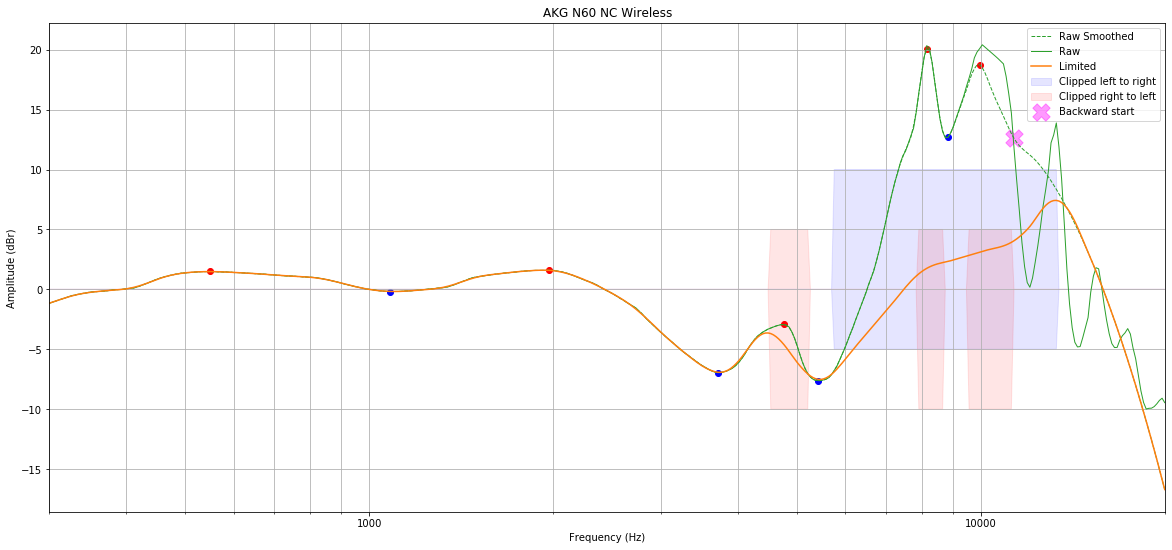

In [6]:
print('Backward start is a problem here because of the significant high frequency roll-off')
limited_slope_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/AKG N60 NC Wireless/AKG N60 NC Wireless.csv'), onear_target), 18)
plt.show()

Adam SP-5 has an elevation between 4 and 6 kHz but is limited only from R2L.
The right side slope is shared by the following notch at 6 kHz. 
6 kHz notch could be left alone between 5.2 kHz and 6.5 kHz


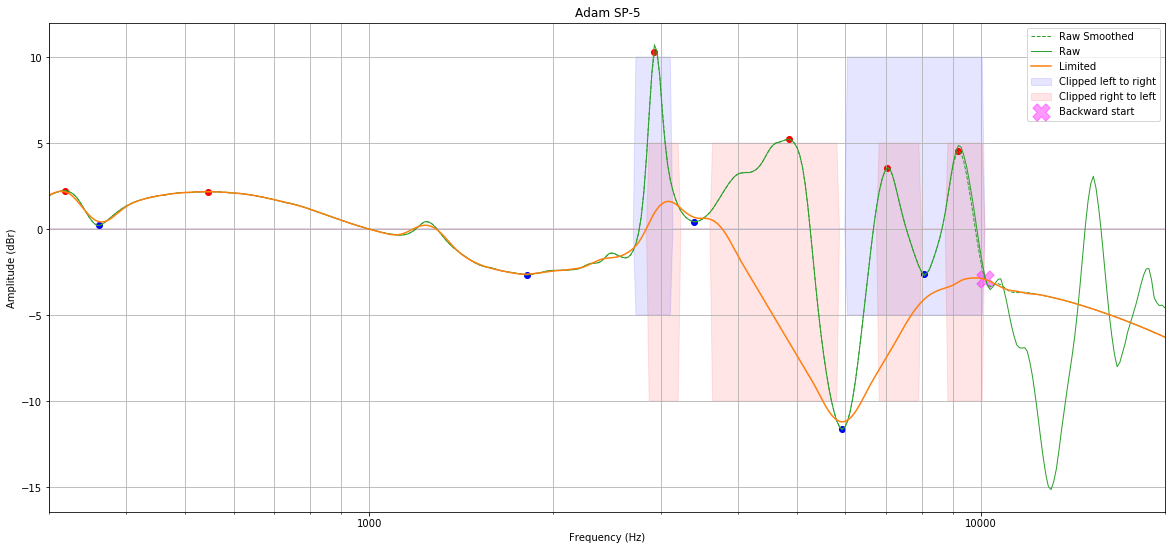

In [49]:
print('Adam SP-5 has an elevation between 4 and 6 kHz but is limited only from R2L.')
print('The right side slope is shared by the following notch at 6 kHz. ')
print('6 kHz notch could be left alone between 5.2 kHz and 6.5 kHz')
limited_slope_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Adam SP-5/Adam SP-5.csv'), onear_target), 18)
plt.show()

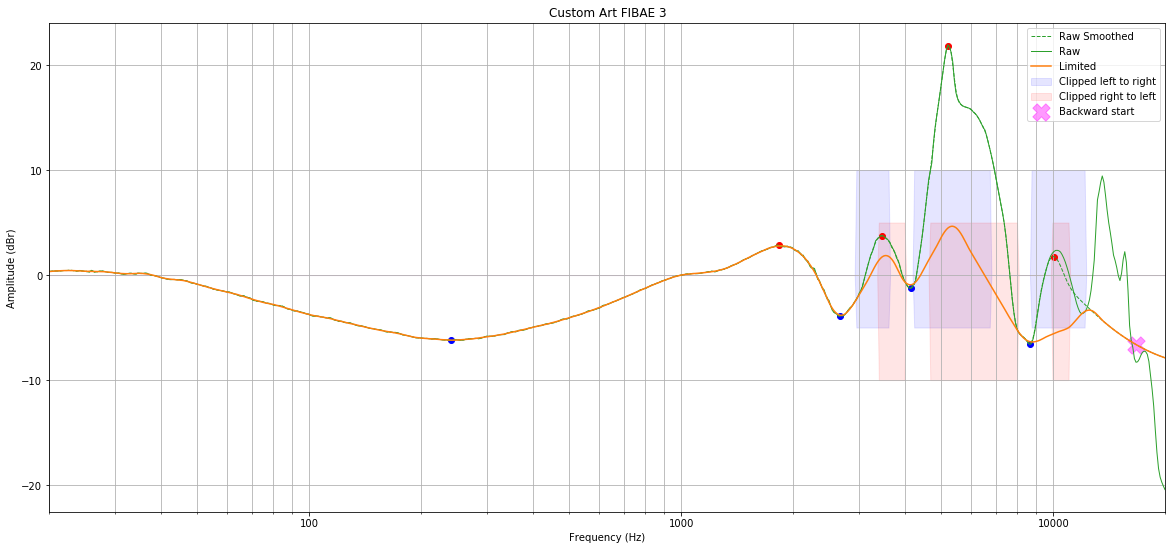

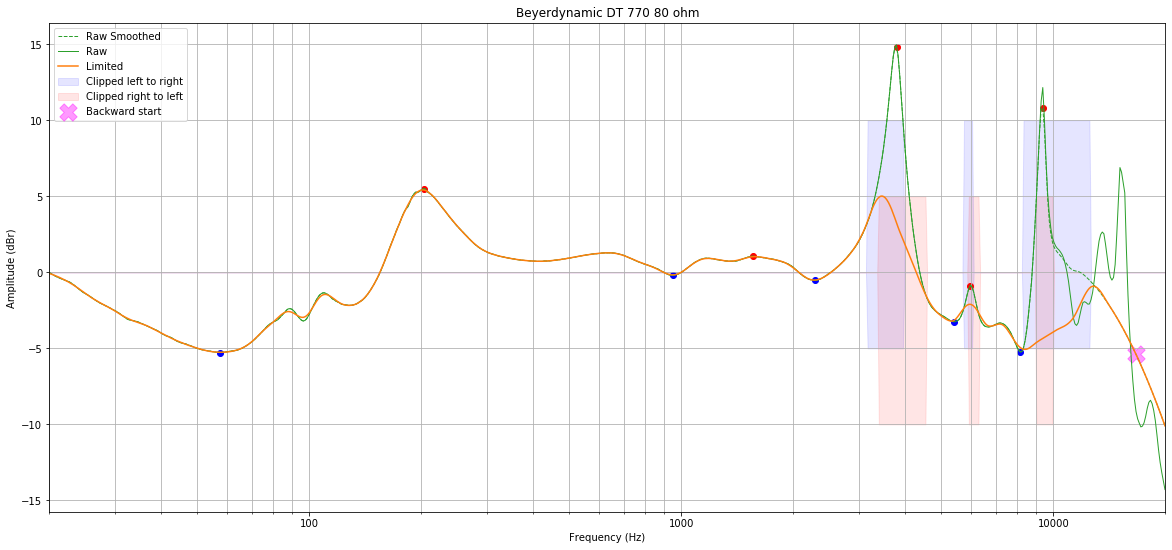

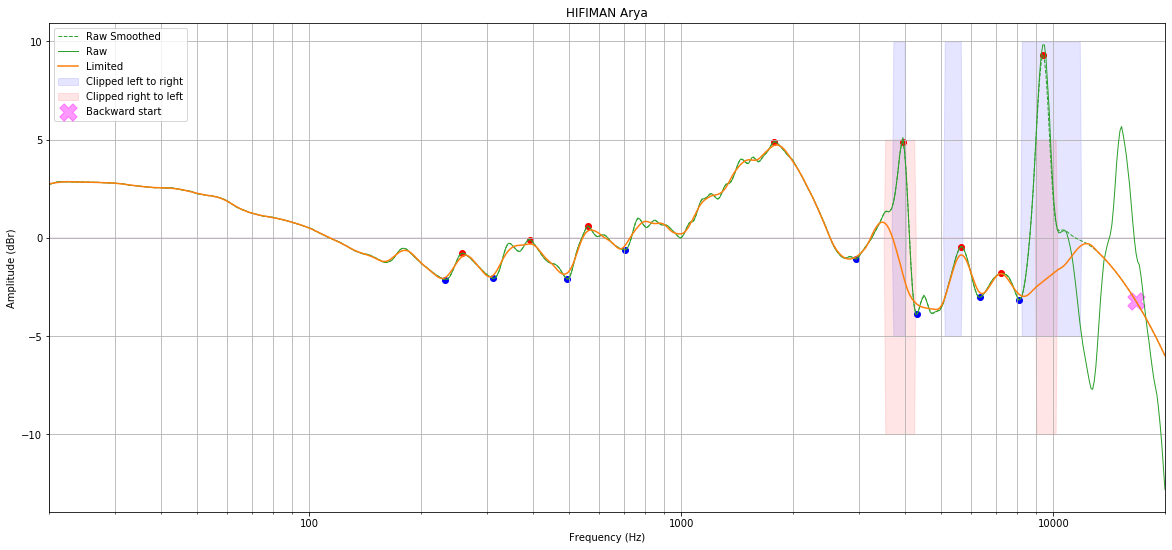

In [34]:
f3 = equalization(ROOT_PATH.joinpath('measurements/crinacle/data/inear/Custom Art FIBAE 3/Custom Art FIBAE 3.csv'), inear_target)
_, _, f3.equalization = limited_slope_plots(f3, 18)
f3.write_eqapo_graphic_eq('Custom Art FIBAE 3 limited.txt', normalize=True)
limited_slope_plots(equalization(
    ROOT_PATH.joinpath('measurements/crinacle/data/onear/GRAS 43AG-7/Beyerdynamic DT 770 80 ohm/Beyerdynamic DT 770 80 ohm.csv'), onear_target), 18)
limited_slope_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/HIFIMAN Arya/HIFIMAN Arya.csv'), onear_target), 18)
plt.show()

Left side of 6.5 kHz notch is limited because of the miniscule 8.1 kHz peak.


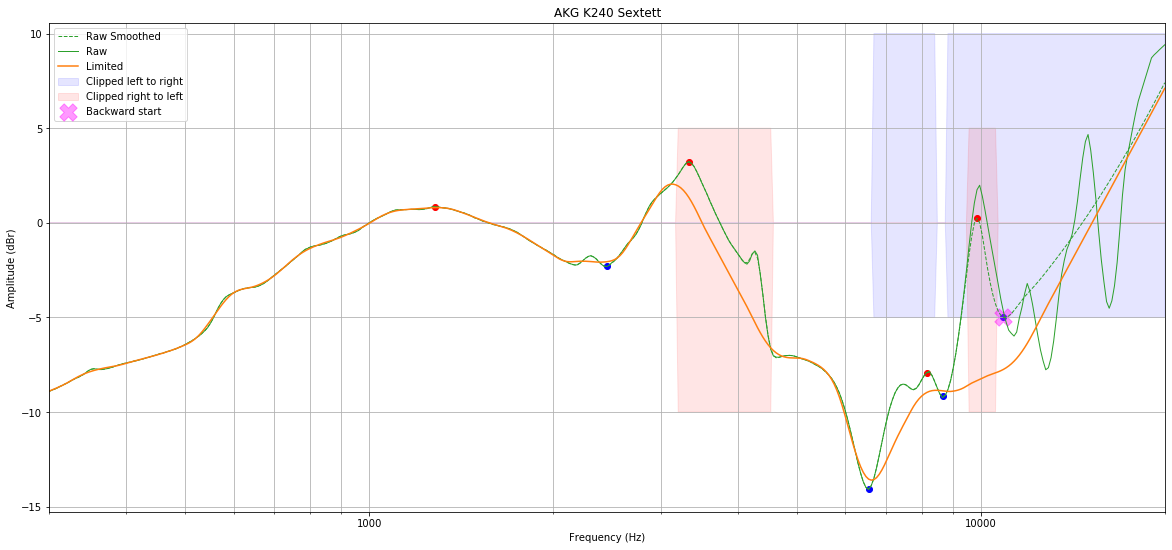

In [51]:
print('Left side of 6.5 kHz notch is limited because of the miniscule 8.1 kHz peak.')
limited_slope_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/AKG K240 Sextett/AKG K240 Sextett.csv'), onear_target), 18)  # 4.20 kHz
plt.show()

Beyerdynamic T1 2nd Generation has a prominent peak at 4800 Hz but is only limited from R2L


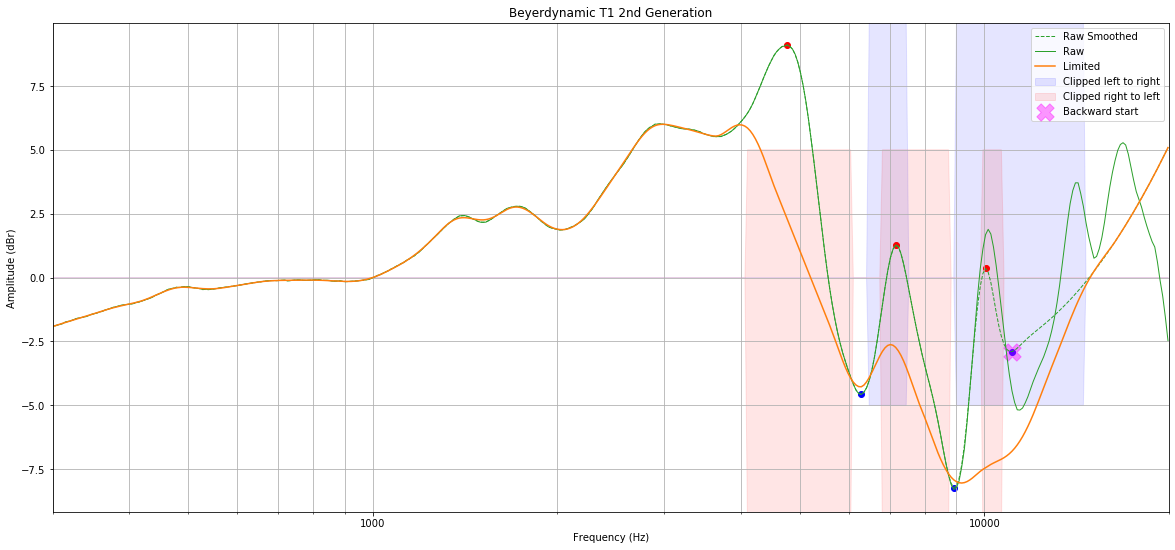

In [52]:
print('Beyerdynamic T1 2nd Generation has a prominent peak at 4800 Hz but is only limited from R2L')
limited_slope_plots(equalization(
    ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Beyerdynamic T1 2nd Generation/Beyerdynamic T1 2nd Generation.csv'), onear_target), 18)  # 4.8 kHz
plt.show()

In [ ]:
img_path = ROOT_PATH.joinpath('research', 'limited_gradient_smoothing', 'img')
img_path.mkdir(exist_ok=True)
for fp in ROOT_PATH.glob('measurements/oratory1990/data/onear/**/*.csv'):
    fr = equalization(fp, onear_target)
    fig, ax = limited_slope_plots(fr, 18)
    fig.savefig(img_path.joinpath(f'{fr.name}.png'))
    plt.close(fig)